In [1]:
# Explore the competition data and learn about the competition topic
# Prepare data for machine learning
# Train a model
# Measure the accuracy of your model
# Prepare and make your first Kaggle submission.

#In this competition, we have a data set of different information about passengers onboard the Titanic, and we see if
#we can use that information to predict whether those people survived or not.

#Data has a number of feature columns which contain various descriptive data, as well as a column of the target values
#we are trying to predict survied or not

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
#code snippet:
import pandas as pd

test = pd.read_csv("test.csv")
train=pd.read_csv("train.csv")
test_shape = test.shape
train_shape=train.shape
print(train_shape,test_shape)

(891, 12) (418, 11)


## Exploring the Data

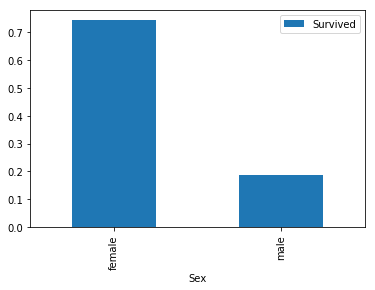

In [27]:
#here is the features we ll be working w

# PassengerID - A column added by Kaggle to identify each row and make submissions easier
# Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
# Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
# Sex - The passenger's sex
# Age - The passenger's age in years
# SibSp - The number of siblings or spouses the passenger had aboard the Titanic
# Parch - The number of parents or children the passenger had aboard the Titanic
# Ticket - The passenger's ticket number
# Fare - The fare the passenger paid
# Cabin - The passenger's cabin number
# Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

#we are performing binary classification, which means that there are only two different states we are classifying.

#domain knowledge is important in ml. understanding the Titanic disaster and specifically what variables
#might affect the outcome of survival is important. Anyone who has watched the movie Titanic would remember that women
#and children were given preference to lifeboats (as they were in real life). You would also remember the vast class
#disparity of the passengers.

#This indicates that Age, Sex, and PClass may be good predictors of survival.We'll start by exploring Sex and Pclass by
#visualizing the data.

#Because the Survived column contains 0 if the passenger did not survive and 1 if they did, we can segment our data by
#sex and calculate the mean of this column. We can use DataFrame.pivot_table() to easily do this:

import matplotlib.pyplot as plt
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

## Exploring and Converting the Age Column

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


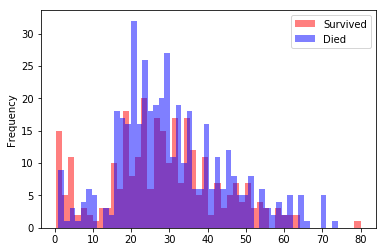

In [28]:
#The Sex and PClass columns are categorical features.That means that the values represented a few separate options
#(for instance, whether the passenger was male or female).

#Let's take a look at the Age column using Series.describe().
print(train["Age"].describe())
#The Age column contains numbers ranging from 0.42 to 80.0. The other thing to note here is that there are 714 vals in
#this column,fewer than the 891 rows we discovered that the train data set had earlier which indicates
#we have some missing values.

#All of this means that the Age column needs to be treated slightly differently, as this is a continuous numerical
#column. One way to look at distribution of values in a continuous numerical set is to use histograms. We can create
#two histograms to compare visually the those that survived vs those who died across different age ranges:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()
#The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red
#bars are higher than the blue bars.

#In order for this to be useful to our machin learning model,we can separate this continuous feature into a categorical
#feature by dividing it into ranges. We can use the pandas.cut() function to help us out.

#The pandas.cut() function has two required parameters - the column we wish to cut, and a list of numbers which define
#the boundaries of our cuts. We are also going to use the optional parameter labels, which takes a list of labels for
#the resultant bins. This will make it easier for us to understand our results.

#Before we modify this column, we have to be aware of two things. Firstly, any change we make to the train data,we also
#need to make to the test data, otherwise we will be unable to use our model to make predictions for our submissions.
#Secondly, we need to remember to handle the missing values we observed above.In the ex below, we create a func that:

#uses the pandas.fillna() method to fill all of the missing values with -0.5
#cuts the Age column into three segments: Missing, Child, and Adult using pandas.cut().

#We then use that function on both the train and test dataframes.

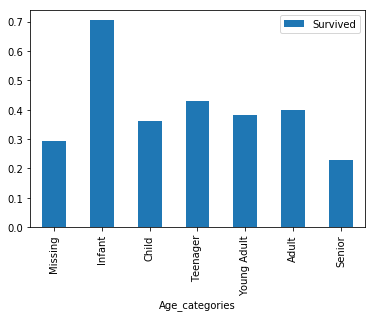

In [29]:
#code snippet:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points=[-1,0,5,12,18,35,60,100]
label_names=["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train=process_age(train,cut_points,label_names)
test=process_age(test,cut_points,label_names)

pivot=train.pivot_table(index="Age_categories",values="Survived")
pivot.plot.bar()
plt.show()

## Preparing Data for Machine Learning

In [30]:
# So far we have identified three columns that may be useful for predicting survival:

# Sex
# Pclass
# Age, and more specifically our newly created Age_categories

#Before we build our model, we need to prepare these columns for machine learning.Most machine learning algorithms cant
#understand text labels, so we have to convert our values into numbers.Additionally, we need to be careful that we dont
#imply any numeric relationship where there isn't one. If we think of the values in the Pclass column, we know they are
#1, 2, and 3. we can confirm this by running the following code:
train["Pclass"].value_counts()
#While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class
#is not the same as the relationship between the numbers 1, 2, and 3. For instance, class 2 isn't "worth" double what
#class 1 is, and class 3 isn't "worth" triple what class 1 is.

#In order to remove this relationship, we can create dummy columns for each unique value in Pclass:
#Rather than doing this manually,we can use the pandas.get_dummies() function, which will generate columns shown in the
#diagram above.The following code creates a function to create the dummy columns for the Pclass column and add it back
#to the original dataframe. It then applies that function the train and test dataframes.

#Let's use that function to create dummy columns for both the Sex and Age_categories columns.

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [31]:
#code snippet:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train=create_dummies(train,"Sex")
test=create_dummies(test,"Sex")

train=create_dummies(train,"Age_categories")
test=create_dummies(test,"Age_categories")


## Creating First Machine Learning Model

In [32]:
#Now that our data has been prepared, we are ready to train our first model. The first model we will use is called
#Logistic Regression, which is often the first model you will train when performing classification.

#We will be using the scikit-learn library as it has many tools that make performing machine learning easier.
#here is the 4 steps that we use for most sklearn process:

# Instantiate (or create) the specific machine learning model you want to use
# Fit the model to the training data
# Use the model to make predictions
# Evaluate the accuracy of the predictions

#Each model in scikit-learn is implemented as a separate class and the first step is to identify the class we want
#to create an instance of. In our case, we want to use the LogisticRegression class.
# from sklearn.linear_model import LogisticRegression
#Next, we create a LogisticRegression object:

#Lastly, we use the LogisticRegression.fit() method to train our model. The .fit() method accepts two arguments: X and
#y. X must be a two dimensional array (like a dataframe) of the features that we wish to train our model on, and y must
#be a one-dimensional array (like a series) of our target, or the column we wish to predict.


In [33]:
#code snippet:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(train[columns],train["Survived"])

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Splitting Training Data

In [34]:
# Our next step is to find out how accurate our model is, and to do that, we'll have to make some predictions.
#we have a test dataframe that we could use to make predictions.We could make predictions
#on that data set, but because it doesn't have the Survived column we would have to submit it to Kaggle to find out our
#accuracy.This would quickly become a pain if we had to submit to find out accuracy every time we optimized our model

#We could also fit and predict on our train dataframe, however if we do this there is a high likelihood that our model
#will overfit,which means it will perform well because we're testing on the same data we've trained on,but then perform
#much worse on new, unseen data.

#Instead we can split our train dataframe into two:
#One part to train our model on (often 80% of the observations)
#One part to make predictions with and test our model (often 20% of the observations)

#convention in machine learning is to call these two parts train and test.This can become confusing, since we already
#have our test dataframe that we will eventually use to make predictions to submit to Kaggle. To avoid confusion, from
#here on, we're going to call this Kaggle 'test' data holdout data which is tech name given to this type of data used
#for final predictions.

#The scikit-learn library has a handy model_selection.train_test_split() function that we can use to split our data.
#train_test_split() accepts two parameters, X and y, which contain all the data we want to train and test on, and
#returns four objects: train_X, train_y, test_X, test_y:

#You'll notice that there are two other parameters we used: test_size, which lets us control what proportions our data
#are split into, and random_state. The train_test_split() function randomizes observations before dividing them, and
#setting a random seed means that our results will be reproducible, which is important if you are collaborating, or
#need to produce consistent results each time

In [35]:
#code snippet:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X=train[columns]
all_y=train["Survived"]

train_X,test_X,train_y,test_y=train_test_split(all_X,all_y,test_size=0.2,random_state=0)

## Making Predictions and Measuring their Accuracy

In [36]:
#There are a number of ways to measure the accuracy of machine learning models,but when competing in Kaggle competition
#we want to make sure we use the same method that Kaggle uses to calculate accuracy for that specific competition.

#In this case, the evaluation section for the Titanic competition on Kaggle tells us that our score calculated as 
#"the % of passengers correctly predicted".This is by far the most common form of accuracy for binary classification.

#In this case, our model correctly predicted three out of five values, so the accuracy based on this prediction set
#would be 60%. Again, scikit-learn has a handy function we can use to calculate accuracy: metrics.accuracy_score().
#The function accepts two parameters, y_true and y_pred, which are the actual vals and our predicted vals respectively
#and returns our accuracy score.


In [37]:
#code snippet:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Using Cross Validation for More Accurate Error Measurement

In [38]:
#Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small
#there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

#To give us a better understanding of the real performance of our model, we can use a technique called cross validation
#to train and test our model on different splits of our data, and then average the accuracy scores.

#The most common form of cross validation, and the one we will be using, is called k-fold cross validation. 'Fold'
#refers to each different iteration that we train our model on, and 'k' just refers to the number of folds.

#We will use scikit-learn's model_selection.cross_val_score() function to automate the process. The basic syntax for
#cross_val_score() is:

#cross_val_score(estimator, X, y, cv=None)

# estimator is a scikit-learn estimator object, like the LogisticRegression() objects we have been creating.
# X is all features from our data set.
# y is the target variables.
# cv specifies the number of folds.

#The function returns a numpy ndarray of the accuracy scores of each fold.
#It's worth noting, the cross_val_score() function can use a variety of cross validation techniques and scoring types,
#but it defaults to k-fold validation and accuracy scores for our input types.

#Note:
#we can also use tr-test-validation set approach.use tr to fit polynomials with degree from 1 to 10
#then use valid set to select best polynomial (with lowest mse error) degree
#then we use test set to find best model's accuracy.split is around 60-20-20 

In [39]:
#code snippet:
from sklearn.model_selection import cross_val_score
import numpy as np
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
0.8024670865963002


C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

## Making predictions on unseen data

In [40]:
#From the results of our k-fold validation, we can see that the accuracy number varies with each fold - ranging btw
#76.4% and 87.6%. This demonstrates why cross validation is important.

#As it happens, our average accuracy score was 80.2%, which is not far from the 81.0% we got from our simple train/test
#split, however this will not always be the case, and you should always use cross-validation to make sure the error
#metrics you are getting from your model are accurate.

In [41]:
#code snippet:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

C:\Users\berka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Creating a Submission File

In [42]:
#The last thing we need to do is create a submission file. Each Kaggle competition can have slightly dif requirements
#for the submission file. Here's what is specified on the Titanic competition evaluation page:

#You should submit a csv file with exactly 418 entries plus a header row.Your submission will show an error if you have
#extra columns (beyond PassengerId and Survived) or rows.

# The file should have exactly 2 columns:

# PassengerId (sorted in any order)
# Survived (contains your binary predictions: 1 for survived, 0 for deceased)

# The table below shows this in a slightly easier to understand format, so we can visualize what we are aiming for.

# PassengerId	Survived
# 892	0
# 893	1
# 894	0

#We will need to create a new dataframe that contains the holdout_predictions we created in the previous screen and the
#PassengerId column from the holdout dataframe. We don't need to worry about matching the data up, as both of these
#remain in their original order.

#To do this, we can pass a dictionary to the pandas.DataFrame() function:

In [43]:
#code snippet:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)